In [17]:
# 1
import math
import csv
from numpy import genfromtxt
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline
np.random.seed(1)

In [18]:
# 16, 17, 18
XY_orig=genfromtxt('imputated_oasis.csv', delimiter=',')
XY_orig=np.matrix(XY_orig)          #original excel dataset
X_orig=XY_orig[1:374, 3:14].T       #eliminate feature-names, labels, unnecessary features and transpose to get X_orig
Y_orig=XY_orig[1:374, 14].T         #extract labels and transpose to get Y
X_orig_max = X_orig.max(1)          #normalizing features
X_orig=X_orig/X_orig_max

X_train=X_orig[:, 0:262]            #split into X_train
Y_train=Y_orig[:, 0:262]            #split into Y_train

X_test=X_orig[:, 262:373]           #split into X_test
Y_test=Y_orig[:, 262:373]           #split into Y_test

X_train=np.array(X_train)           #convert to array from matrices
X_test=np.array(X_test)
Y_train=np.array(Y_train)
Y_test=np.array(Y_test)

Y_train=Y_train.astype(int)         #convert to one-hot
Y_test=Y_test.astype(int)
Y_train=convert_to_one_hot(Y_train, 3)
Y_test=convert_to_one_hot(Y_test, 3)

print ("number of training examples = " + str(X_train.shape[1]))      #print out dimensions
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))


number of training examples = 262
number of test examples = 111
X_train shape: (11, 262)
Y_train shape: (3, 262)
X_test shape: (11, 111)
Y_test shape: (3, 111)


In [19]:
# 19
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    ### START CODE HERE ### (approx. 2 lines)
    X = tf.placeholder(tf.float32, [n_x, None])
    Y = tf.placeholder(tf.float32, [n_y, None])
    ### END CODE HERE ###
    
    return X, Y

In [20]:
# 21
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [10, 10]
                        b1 : [10, 1]
                        W2 : [10, 10]
                        b2 : [10, 1]
                        W3 : [3, 10]
                        b3 : [3, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 6 lines of code)
    W1 = tf.get_variable("W1", [11, 11], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [11, 1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [11, 11], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [11, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [3, 11], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [3, 1], initializer = tf.zeros_initializer())
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters


In [21]:
# 23
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    ### START CODE HERE ### (approx. 5 lines)                                      # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                                              # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                                            # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                                             # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                                            # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                                             # Z3 = np.dot(W3,Z2) + b3
    ### END CODE HERE ###
    
    return Z3


In [22]:
# 25
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    ### END CODE HERE ###
    
    return cost

In [23]:
# 27
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_x, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
        print()

        # Calculate accuracies
        #Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        print()
        
        # Calculating recall for category 0
        predicted0_actual0 = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(tf.argmax(Z3), 0), tf.equal(tf.argmax(Y), 0)), "float"))
        predicted1_actual0 = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(tf.argmax(Z3), 1), tf.equal(tf.argmax(Y), 0)), "float"))
        predicted2_actual0 = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(tf.argmax(Z3), 2), tf.equal(tf.argmax(Y), 0)), "float")) 
        recall0=tf.divide(predicted0_actual0, tf.add_n([predicted0_actual0, predicted1_actual0, predicted2_actual0]))
        print ("Train Recall for category 0:", recall0.eval({X: X_train, Y: Y_train}))
        print ("Test Recall for category 0:", recall0.eval({X: X_test, Y: Y_test}))
        print()
        
        # Calculating recall for category 1
        predicted1_actual1 = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(tf.argmax(Z3), 1), tf.equal(tf.argmax(Y), 1)), "float"))
        predicted0_actual1 = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(tf.argmax(Z3), 0), tf.equal(tf.argmax(Y), 1)), "float"))
        predicted2_actual1 = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(tf.argmax(Z3), 2), tf.equal(tf.argmax(Y), 1)), "float")) 
        recall1=tf.divide(predicted1_actual1, tf.add_n([predicted1_actual1, predicted0_actual1, predicted2_actual1]))
        print ("Train Recall for category 1:", recall1.eval({X: X_train, Y: Y_train}))
        print ("Test Recall for category 1:", recall1.eval({X: X_test, Y: Y_test}))
        print()
        
        # Calculating precision for category 0
        predicted0_actual0 = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(tf.argmax(Z3), 0), tf.equal(tf.argmax(Y), 0)), "float"))
        predicted0_actual1 = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(tf.argmax(Z3), 0), tf.equal(tf.argmax(Y), 1)), "float"))
        predicted0_actual2 = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(tf.argmax(Z3), 0), tf.equal(tf.argmax(Y), 2)), "float")) 
        precission0=tf.divide(predicted0_actual0, tf.add_n([predicted0_actual0, predicted0_actual1, predicted0_actual2]))
        print ("Train Precission for category 0:", precission0.eval({X: X_train, Y: Y_train}))
        print ("Test Precission for category 0:", precission0.eval({X: X_test, Y: Y_test}))
        print()
        
        # Calculating precision for category 1
        predicted1_actual1 = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(tf.argmax(Z3), 1), tf.equal(tf.argmax(Y), 1)), "float"))
        predicted1_actual0 = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(tf.argmax(Z3), 1), tf.equal(tf.argmax(Y), 0)), "float"))
        predicted1_actual2 = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(tf.argmax(Z3), 1), tf.equal(tf.argmax(Y), 2)), "float")) 
        precission1=tf.divide(predicted1_actual1, tf.add_n([predicted1_actual1, predicted1_actual0, predicted1_actual2]))
        print ("Train Precission for category 1:", precission1.eval({X: X_train, Y: Y_train}))
        print ("Test Precission for category 1:", precission1.eval({X: X_test, Y: Y_test}))
        print()
        
        return parameters
    

Cost after epoch 0: 1.293578
Cost after epoch 100: 1.027081
Cost after epoch 200: 0.995648
Cost after epoch 300: 0.954410
Cost after epoch 400: 0.799268
Cost after epoch 500: 0.741288
Cost after epoch 600: 0.604568
Cost after epoch 700: 0.485072
Cost after epoch 800: 0.460242
Cost after epoch 900: 0.368791
Cost after epoch 1000: 0.329395
Cost after epoch 1100: 0.328596
Cost after epoch 1200: 0.354796
Cost after epoch 1300: 0.272005
Cost after epoch 1400: 0.259094


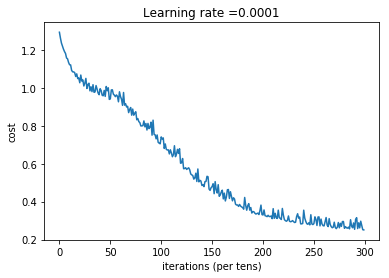

Parameters have been trained!

Train Accuracy: 0.92748094
Test Accuracy: 0.8558559

Train Recall for category 0: 0.9852941
Test Recall for category 0: 1.0

Train Recall for category 1: 1.0
Test Recall for category 1: 0.95238096

Train Precission for category 0: 0.91780823
Test Precission for category 0: 0.85714287

Train Precission for category 1: 0.9369369
Test Precission for category 1: 0.8695652



In [24]:
# 28
parameters = model(X_train, Y_train, X_test, Y_test)
